Unified preprocessing pipeline for Tox21:
- Loads Tox21 dataset (SMILES + labels)
- Creates scaffold-based train/val/test splits
- Exports:
    - Graph datasets (for GNNs, PyTorch Geometric)
    - Molecular-level descriptors/fingerprints (for baseline ML)
    - Split metadata (so both use identical molecules)

In [1]:
# import necessary libraries

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, Descriptors
import torch
from torch_geometric.data import Data
import deepchem as dc

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named '

In [2]:
# set random seed for reproducibility

np.random.seed(42)
torch.manual_seed(42)
os.makedirs("tox21_processed_updated", exist_ok=True)

In [3]:
print("📥 Loading Tox21 dataset...")
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer="Raw", data_dir=".", save_dir=".")
train_dataset, valid_dataset, test_dataset = datasets

# print(type(train_dataset))


📥 Loading Tox21 dataset...


In [4]:
# convert datasets to pandas DataFrames for easier manipulation
train_df = train_dataset.to_dataframe()
valid_df = valid_dataset.to_dataframe()
test_df = test_dataset.to_dataframe()

# map tasks to column names such as tasks[0] is y1 column, replace it with tasks[0]
for i, task in enumerate(tasks):
    train_df.rename(columns={f'y{i+1}': task}, inplace=True)
    valid_df.rename(columns={f'y{i+1}': task}, inplace=True)
    test_df.rename(columns={f'y{i+1}': task}, inplace=True)

# save raw data to CSV files
train_df.to_csv("tox21_processed/train_raw.csv", index=False)
valid_df.to_csv("tox21_processed/valid_raw.csv", index=False)
test_df.to_csv("tox21_processed/test_raw.csv", index=False)

In [5]:
# do some basic EDA
print(f"Number of tasks: {len(tasks)}")
print(f"Tasks: {tasks}")
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")
print("Sample data:")
print(train_df.head())

print("✅ Data loading and initial processing complete.")

Number of tasks: 12
Tasks: ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']
Training set size: 6258
Validation set size: 782
Test set size: 783
Sample data:
                                                   X  NR-AR  NR-AR-LBD  \
0  <rdkit.Chem.rdchem.Mol object at 0x00000249B4E...    0.0        0.0   
1  <rdkit.Chem.rdchem.Mol object at 0x00000249B4E...    0.0        0.0   
2  <rdkit.Chem.rdchem.Mol object at 0x00000249B4D...    0.0        0.0   
3  <rdkit.Chem.rdchem.Mol object at 0x00000249B4E...    0.0        0.0   
4  <rdkit.Chem.rdchem.Mol object at 0x00000249B4E...    0.0        0.0   

   NR-AhR  NR-Aromatase  NR-ER  NR-ER-LBD  NR-PPAR-gamma  SR-ARE  SR-ATAD5  \
0     0.0           0.0    0.0        0.0            0.0     0.0       0.0   
1     0.0           0.0    0.0        0.0            0.0     0.0       0.0   
2     0.0           0.0    0.0        0.0            0.0     0.0       0.

Missing values in training set:
X                0
NR-AR            0
NR-AR-LBD        0
NR-AhR           0
NR-Aromatase     0
NR-ER            0
NR-ER-LBD        0
NR-PPAR-gamma    0
SR-ARE           0
SR-ATAD5         0
SR-HSE           0
SR-MMP           0
SR-p53           0
w1               0
w2               0
w3               0
w4               0
w5               0
w6               0
w7               0
w8               0
w9               0
w10              0
w11              0
w12              0
ids              0
dtype: int64
Missing values in validation set:
X                0
NR-AR            0
NR-AR-LBD        0
NR-AhR           0
NR-Aromatase     0
NR-ER            0
NR-ER-LBD        0
NR-PPAR-gamma    0
SR-ARE           0
SR-ATAD5         0
SR-HSE           0
SR-MMP           0
SR-p53           0
w1               0
w2               0
w3               0
w4               0
w5               0
w6               0
w7               0
w8               0
w9               0
w10      

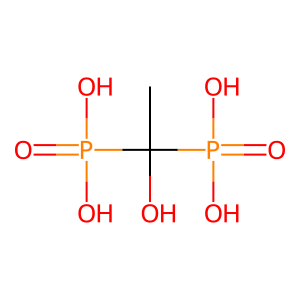

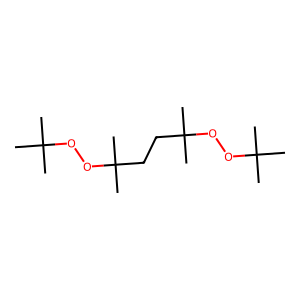

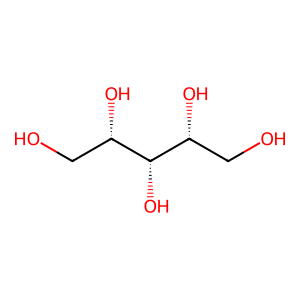

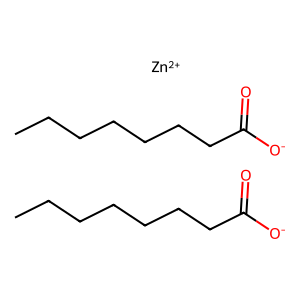

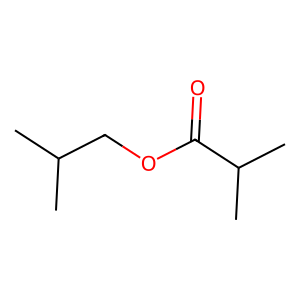

In [6]:
# do some EDA based on the dataframes

# check for missing values
print("Missing values in training set:")
print(train_df.isnull().sum())
print("Missing values in validation set:")
print(valid_df.isnull().sum())
print("Missing values in test set:")
print(test_df.isnull().sum())

# distribution of labels for each task
for task in tasks:
    print(f"Label distribution for task {task} in training set:")
    print(train_df[task].value_counts(dropna=False))
    print(f"Label distribution for task {task} in validation set:")
    print(valid_df[task].value_counts(dropna=False))
    print(f"Label distribution for task {task} in test set:")
    print(test_df[task].value_counts(dropna=False))

# visualize some molecules
print("Sample molecules from training set:")
for smi in train_df['ids'].head(5):
    mol = Chem.MolFromSmiles(smi)
    display(Chem.Draw.MolToImage(mol))

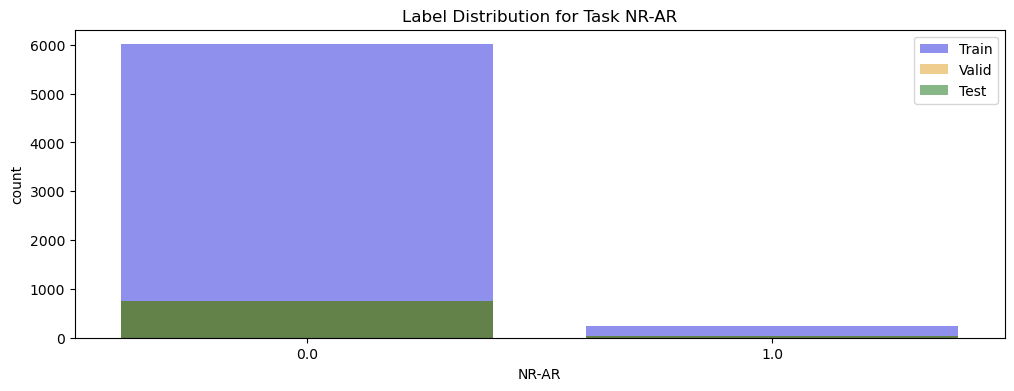

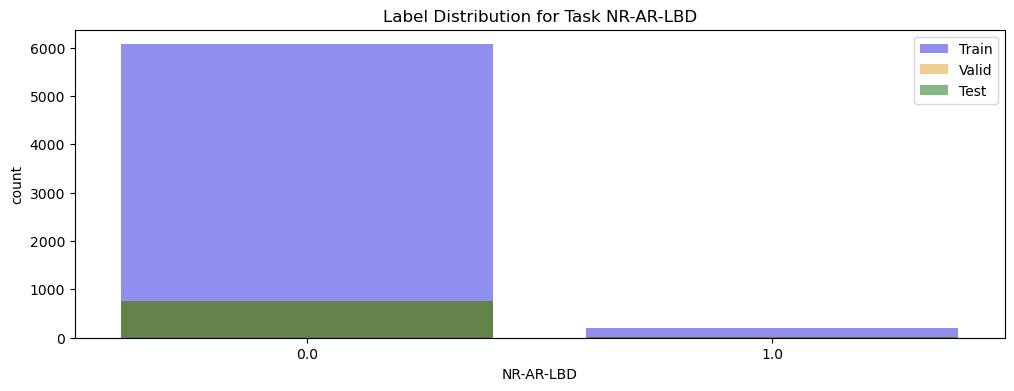

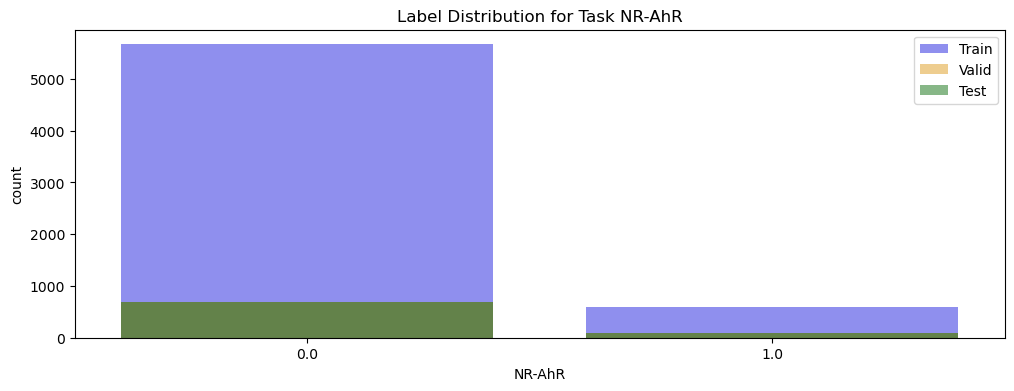

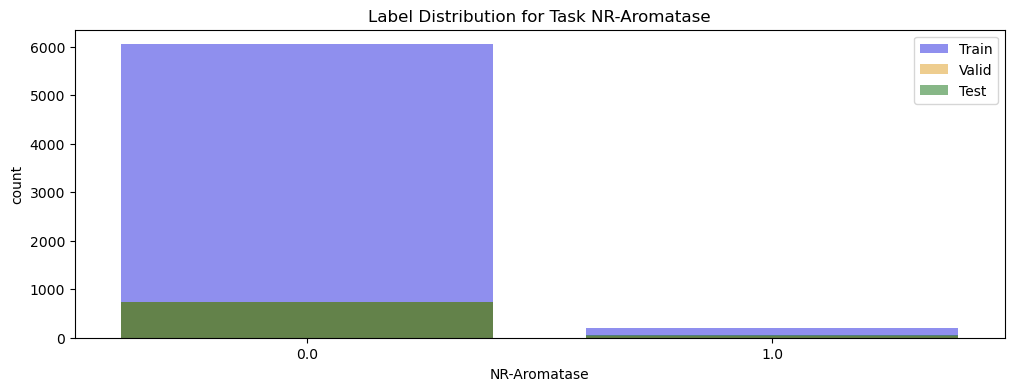

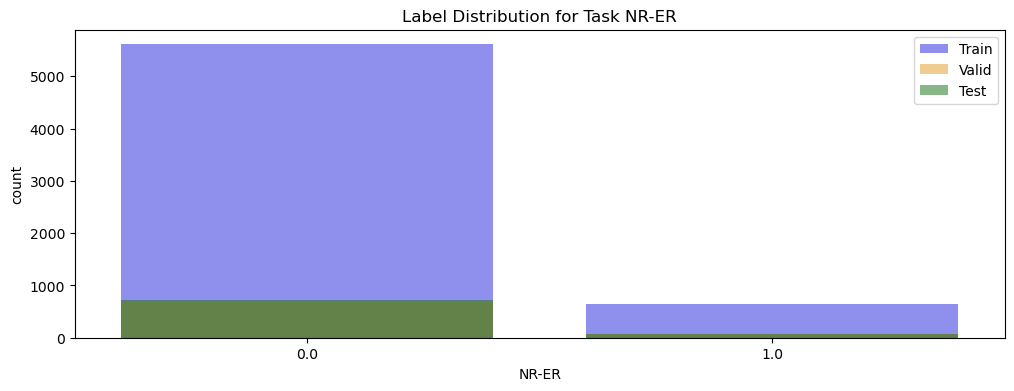

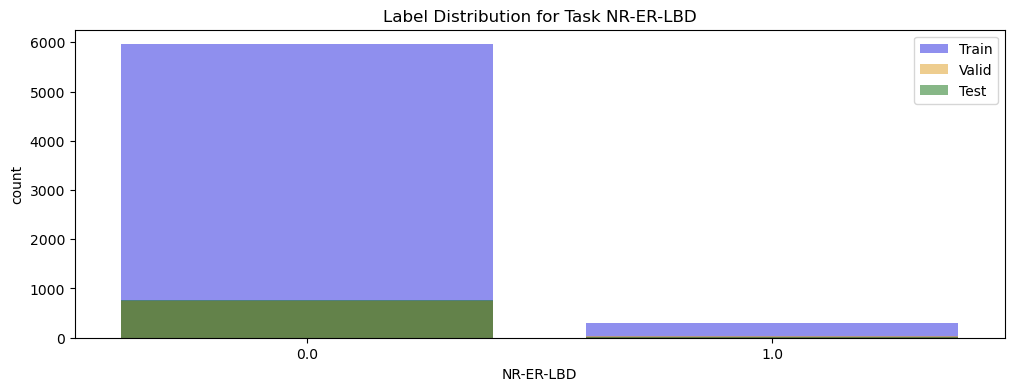

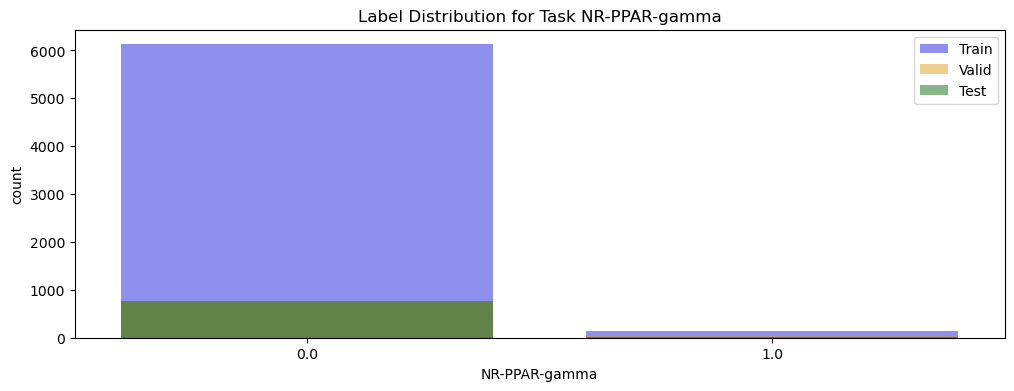

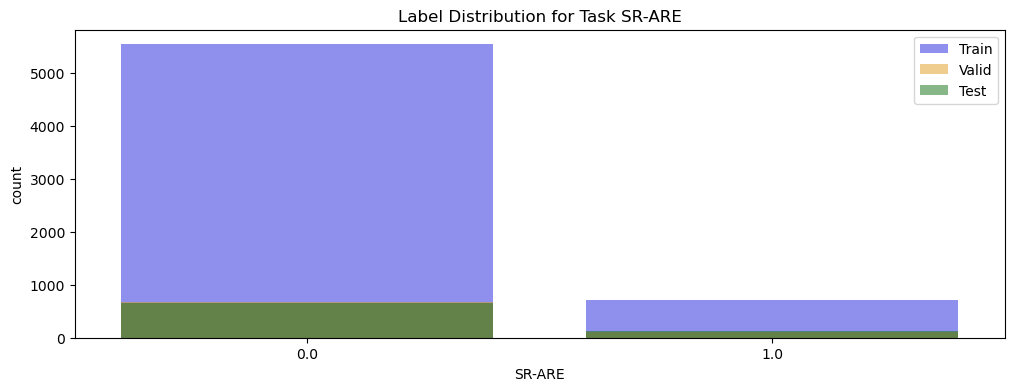

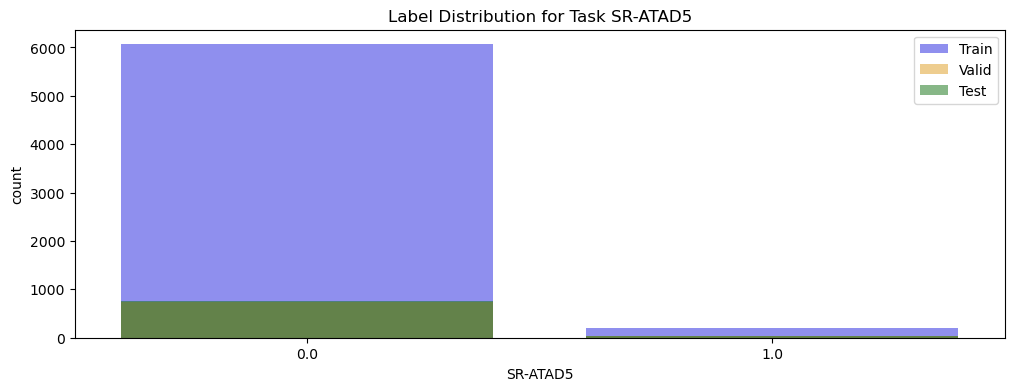

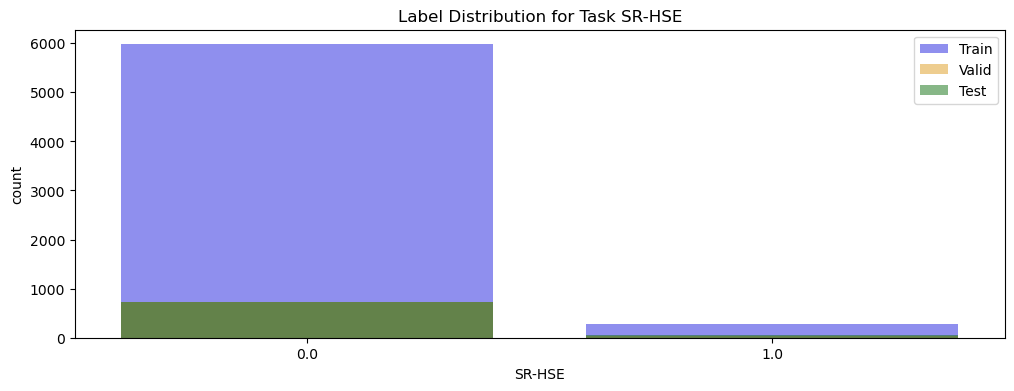

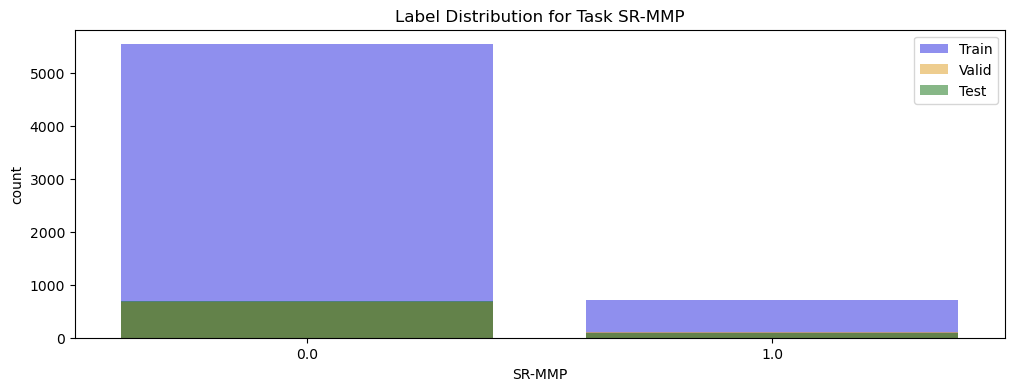

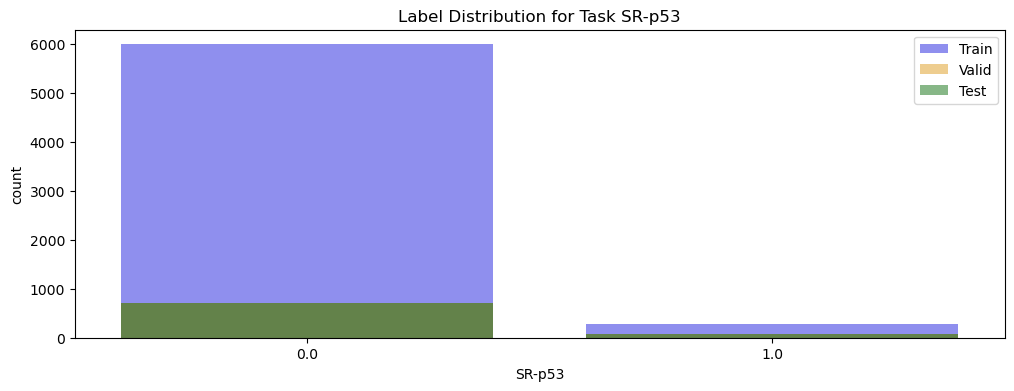

In [7]:
# do some visualizations of label distributions in the same plot
import matplotlib.pyplot as plt
import seaborn as sns
for task in tasks:
    plt.figure(figsize=(12, 4))
    sns.countplot(x=task, data=train_df, label='Train', color='blue', alpha=0.5)
    sns.countplot(x=task, data=valid_df, label='Valid', color='orange', alpha=0.5)
    sns.countplot(x=task, data=test_df, label='Test', color='green', alpha=0.5)
    plt.title(f"Label Distribution for Task {task}")
    plt.legend()
    plt.show()

Extract molecular features for training basic machine learning models.

In [8]:
# extract molecular features using RDKit and save to CSV files
def featurize_molecule(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    features = {}
    # Basic descriptors
    features['MolWt'] = Descriptors.MolWt(mol)
    features['NumHDonors'] = Descriptors.NumHDonors(mol)
    features['NumHAcceptors'] = Descriptors.NumHAcceptors(mol)
    features['TPSA'] = Descriptors.TPSA(mol)
    features['LogP'] = Descriptors.MolLogP(mol)
    # MACCS keys
    maccs = MACCSkeys.GenMACCSKeys(mol)
    for i in range(167):
        features[f'MACCS_{i}'] = int(maccs.GetBit(i))
    # Morgan fingerprint
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    for i in range(2048):
        features[f'Morgan_{i}'] = int(morgan_fp.GetBit(i))
    return features

def featurize_dataset(df):
    feature_list = []
    for smi in tqdm(df['ids'], desc="Featurizing molecules"):
        feats = featurize_molecule(smi)
        if feats is not None:
            feature_list.append(feats)
        else:
            feature_list.append({})  # Append empty dict for invalid SMILES
    features_df = pd.DataFrame(feature_list)
    return pd.concat([df.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)

train_features_df = featurize_dataset(train_df)
valid_features_df = featurize_dataset(valid_df)
test_features_df = featurize_dataset(test_df)

# save featurized data to CSV files
train_features_df.to_csv("tox21_processed/train_featurized.csv", index=False)
valid_features_df.to_csv("tox21_processed/valid_featurized.csv", index=False)   
test_features_df.to_csv("tox21_processed/test_featurized.csv", index=False)

Featurizing molecules:   0%|          | 0/6258 [00:00<?, ?it/s][19:09:07] DEPRECATION WARNING: please use MorganGenerator
[19:09:07] DEPRECATION WARNING: please use MorganGenerator
[19:09:07] DEPRECATION WARNING: please use MorganGenerator
[19:09:07] DEPRECATION WARNING: please use MorganGenerator
[19:09:07] DEPRECATION WARNING: please use MorganGenerator
[19:09:07] DEPRECATION WARNING: please use MorganGenerator
[19:09:07] DEPRECATION WARNING: please use MorganGenerator
[19:09:07] DEPRECATION WARNING: please use MorganGenerator
[19:09:07] DEPRECATION WARNING: please use MorganGenerator
[19:09:07] DEPRECATION WARNING: please use MorganGenerator
[19:09:07] DEPRECATION WARNING: please use MorganGenerator
[19:09:07] DEPRECATION WARNING: please use MorganGenerator
[19:09:07] DEPRECATION WARNING: please use MorganGenerator
[19:09:07] DEPRECATION WARNING: please use MorganGenerator
[19:09:07] DEPRECATION WARNING: please use MorganGenerator
[19:09:07] DEPRECATION WARNING: please use MorganGen

In [9]:
# check the new dataframes
print("Featurized training set sample:")
print(train_features_df.head())

Featurized training set sample:
                                                   X  NR-AR  NR-AR-LBD  \
0  <rdkit.Chem.rdchem.Mol object at 0x00000249B4E...    0.0        0.0   
1  <rdkit.Chem.rdchem.Mol object at 0x00000249B4E...    0.0        0.0   
2  <rdkit.Chem.rdchem.Mol object at 0x00000249B4D...    0.0        0.0   
3  <rdkit.Chem.rdchem.Mol object at 0x00000249B4E...    0.0        0.0   
4  <rdkit.Chem.rdchem.Mol object at 0x00000249B4E...    0.0        0.0   

   NR-AhR  NR-Aromatase  NR-ER  NR-ER-LBD  NR-PPAR-gamma  SR-ARE  SR-ATAD5  \
0     0.0           0.0    0.0        0.0            0.0     0.0       0.0   
1     0.0           0.0    0.0        0.0            0.0     0.0       0.0   
2     0.0           0.0    0.0        0.0            0.0     0.0       0.0   
3     0.0           0.0    0.0        0.0            0.0     0.0       0.0   
4     0.0           0.0    0.0        0.0            0.0     0.0       0.0   

   ...  Morgan_2038  Morgan_2039  Morgan_2040  Morgan_

In [10]:
# do some EDA on the featurized data
print("Featurized training set info:")
print(train_features_df.info())
print("Featurized validation set info:")
print(valid_features_df.info())
print("Featurized test set info:")
print(test_features_df.info())
print("✅ Featurization complete.")

Featurized training set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6258 entries, 0 to 6257
Columns: 2246 entries, X to Morgan_2047
dtypes: float64(27), int64(2217), object(2)
memory usage: 107.2+ MB
None
Featurized validation set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Columns: 2246 entries, X to Morgan_2047
dtypes: float64(27), int64(2217), object(2)
memory usage: 13.4+ MB
None
Featurized test set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Columns: 2246 entries, X to Morgan_2047
dtypes: float64(27), int64(2217), object(2)
memory usage: 13.4+ MB
None
✅ Featurization complete.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6258 entries, 0 to 6257
Columns: 2246 entries, X to Morgan_2047
dtypes: float64(27), int64(2217), object(2)
memory usage: 107.2+ MB
None
Featurized validation set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Columns: 2246 entries, X to Morgan_2047


In [11]:
# print the object type columns to verify
print(train_features_df.select_dtypes(include=['object']).columns)

Index(['X', 'ids'], dtype='object')


In [12]:
#check for any remaining missing values
print("Missing values in featurized training set:")
print(train_features_df.isnull().sum().sum())
print("Missing values in featurized validation set:")
print(valid_features_df.isnull().sum().sum())
print("Missing values in featurized test set:")
print(test_features_df.isnull().sum().sum())

Missing values in featurized training set:
0
Missing values in featurized validation set:
0
Missing values in featurized test set:
0
0
Missing values in featurized validation set:
0
Missing values in featurized test set:
0


In [13]:
# normalize continuous features
from sklearn.preprocessing import StandardScaler
continuous_features = ['MolWt', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'LogP']
scaler = StandardScaler()
train_features_df[continuous_features] = scaler.fit_transform(train_features_df[continuous_features])
valid_features_df[continuous_features] = scaler.transform(valid_features_df[continuous_features])
test_features_df[continuous_features] = scaler.transform(test_features_df[continuous_features])
print("✅ Normalization complete.")

✅ Normalization complete.


In [14]:
# save normalized data to CSV files
train_features_df.to_csv("tox21_processed/train_normalized.csv", index=False)
valid_features_df.to_csv("tox21_processed/valid_normalized.csv", index=False)
test_features_df.to_csv("tox21_processed/test_normalized.csv", index=False)
print("✅ Data processing pipeline complete. Processed files saved in 'tox21_processed' directory.")

✅ Data processing pipeline complete. Processed files saved in 'tox21_processed' directory.


In [15]:
# train a simple model to verify the pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
X_train = train_features_df[continuous_features + [col for col in train_features_df.columns if col.startswith('MACCS_') or col.startswith('Morgan_')]]
y_train = train_features_df[tasks].fillna(0).astype(int)
X_valid = valid_features_df[continuous_features + [col for col in valid_features_df.columns if col.startswith('MACCS_') or col.startswith('Morgan_')]]
y_valid = valid_features_df[tasks].fillna(0).astype(int)
X_test = test_features_df[continuous_features + [col for col in test_features_df.columns if col.startswith('MACCS_') or col.startswith('Morgan_')]]
y_test = test_features_df[tasks].fillna(0).astype(int)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Classification report on test set:")
print(classification_report(y_test, y_pred, zero_division=0))

print("✅ Model training and evaluation complete.")

Classification report on test set:
              precision    recall  f1-score   support

           0       0.90      0.33      0.49        27
           1       0.67      0.21      0.32        19
           2       0.64      0.10      0.17        92
           3       0.67      0.04      0.08        47
           4       0.62      0.07      0.13        70
           5       0.50      0.14      0.22        21
           6       0.00      0.00      0.00        22
           7       0.50      0.03      0.06       118
           8       0.00      0.00      0.00        33
           9       1.00      0.02      0.04        47
          10       0.56      0.05      0.10        96
          11       0.67      0.03      0.05        72

   micro avg       0.65      0.07      0.12       664
   macro avg       0.56      0.09      0.14       664
weighted avg       0.59      0.07      0.11       664
 samples avg       0.03      0.02      0.02       664

✅ Model training and evaluation complete.


In [16]:
# which model is better for multi-label classification?
# try XGBoost, LightGBM, and a simple neural network

# try XGBoost
import xgboost as xgb
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_xgb_pred = xgb_model.predict(X_test)
print("XGBoost Classification report on test set:")
print(classification_report(y_test, y_xgb_pred, zero_division=0))
# calculate roc_auc_score for each task
from sklearn.metrics import roc_auc_score
for i, task in enumerate(tasks):
    try:
        auc = roc_auc_score(y_test[task], y_xgb_pred[:, i])
        print(f"ROC AUC for task {task}: {auc:.4f}")
    except ValueError:
        print(f"ROC AUC for task {task}: Cannot be computed (only one class present in y_true)")
        continue
print("✅ XGBoost model training and evaluation complete.")

c:\Users\USER\miniconda3\envs\tox21_gnn\lib\site-packages\xgboost\core.py:158: UserWarning: [19:10:32] WARNING: D:\bld\xgboost-split_1744329010901\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification report on test set:
              precision    recall  f1-score   support

           0       0.73      0.30      0.42        27
           1       0.71      0.26      0.38        19
           2       0.40      0.23      0.29        92
           3       0.50      0.15      0.23        47
           4       0.58      0.16      0.25        70
           5       0.29      0.10      0.14        21
           6       0.00      0.00      0.00        22
           7       0.36      0.08      0.14       118
           8       0.00      0.00      0.00        33
           9       0.50      0.11      0.18        47
          10       0.50      0.16      0.24        96
          11       0.67      0.11      0.19        72

   micro avg       0.47      0.14      0.21       664
   macro avg       0.44      0.14      0.20       664
weighted avg       0.45      0.14      0.21       664
 samples avg       0.07      0.05      0.05       664

ROC AUC for task NR-AR: 0.6462
ROC A

In [17]:
# try a simple neural network
import torch.nn as nn
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
nn_model = SimpleNN(input_dim, output_dim)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)
# convert data to torch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# train the neural network
num_epochs = 20
for epoch in range(num_epochs):
    nn_model.train()
    optimizer.zero_grad()
    outputs = nn_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
# evaluate the neural network
nn_model.eval()
with torch.no_grad():
    y_nn_pred = nn_model(X_test_tensor)
    y_nn_pred = (y_nn_pred.numpy() > 0.5).astype(int)
print("Neural Network Classification report on test set:")
print(classification_report(y_test, y_nn_pred, zero_division=0))
# calculate roc_auc_score for each task
for i, task in enumerate(tasks):
    try:
        auc = roc_auc_score(y_test[task], y_nn_pred[:, i])
        print(f"ROC AUC for task {task}: {auc:.4f}")
    except ValueError:
        print(f"ROC AUC for task {task}: Cannot be computed (only one class present in y_true)")
        continue
print("✅ Neural Network model training and evaluation complete.")

Epoch [5/20], Loss: 0.6186
Epoch [10/20], Loss: 0.4018
Epoch [10/20], Loss: 0.4018
Epoch [15/20], Loss: 0.2742
Epoch [15/20], Loss: 0.2742
Epoch [20/20], Loss: 0.2873
Epoch [20/20], Loss: 0.2873
Neural Network Classification report on test set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00        92
           3       0.00      0.00      0.00        47
           4       0.00      0.00      0.00        70
           5       0.00      0.00      0.00        21
           6       0.00      0.00      0.00        22
           7       0.00      0.00      0.00       118
           8       0.00      0.00      0.00        33
           9       0.00      0.00      0.00        47
          10       0.00      0.00      0.00        96
          11       0.00      0.00      0.00        72

   micro avg       0.00      0.00      0.00       6

Extract graph features for training graph machine learning models.

In [18]:
# convert data to graph format for graph neural networks
def mol_to_graph_data_obj(mol, df, weights_map=None):
    if mol is None:
        return None
    # node features
    atom_features_list = []
    # Feature layout (feat_dim = 19):
    # [atomic_num, mass, degree, total_num_Hs, formal_charge,
    #  hybridization_onehot(7: S,SP,SP2,SP3,SP2D,SP3D,SP3D2,OTHER),
    #  is_aromatic,
    #  chirality_onehot(3: UNSPECIFIED,CW,CCW),
    #  is_in_ring] 
    for atom in mol.GetAtoms():
        atom_features = []
        atom_features.append(atom.GetAtomicNum())
        atom_features.append(atom.GetMass())
        atom_features.append(atom.GetDegree())
        atom_features.append(atom.GetTotalNumHs())
        atom_features.append(atom.GetFormalCharge())
        hybridization = atom.GetHybridization()
        # consider hybridization as one-hot encoding
        atom_features.append(int(hybridization == Chem.rdchem.HybridizationType.S))
        atom_features.append(int(hybridization == Chem.rdchem.HybridizationType.SP))
        atom_features.append(int(hybridization == Chem.rdchem.HybridizationType.SP2))
        atom_features.append(int(hybridization == Chem.rdchem.HybridizationType.SP3))
        atom_features.append(int(hybridization == Chem.rdchem.HybridizationType.SP2D))
        atom_features.append(int(hybridization == Chem.rdchem.HybridizationType.SP3D))
        atom_features.append(int(hybridization == Chem.rdchem.HybridizationType.SP3D2))
        atom_features.append(int(hybridization == Chem.rdchem.HybridizationType.OTHER))
        atom_features.append(int(atom.GetIsAromatic()))
        chirality= atom.GetChiralTag()
        # one-hot encoding for chirality
        atom_features.append(int(chirality == Chem.rdchem.ChiralType.CHI_UNSPECIFIED))
        atom_features.append(int(chirality == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW))
        atom_features.append(int(chirality == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW))
        atom_features.append(atom.IsInRing())
        atom_features_list.append(atom_features)
    # standardize node features to tensor
    x = torch.tensor(atom_features_list, dtype=torch.float)

    # edge index and edge features
    # Feature layout (feat_dim = 10):
    # [bond_type_onehot(4: S,D,T,A), is_conjugated(1), is_in_ring(1), stereo_onehot(4: NONE,Z,E,ANY)]
    edge_index = []
    edge_attr = []
    feat_dim = 10
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))

        bt = bond.GetBondType()
        if bt == Chem.rdchem.BondType.SINGLE:
            bt_feat = [1, 0, 0, 0]
        elif bt == Chem.rdchem.BondType.DOUBLE:
            bt_feat = [0, 1, 0, 0]
        elif bt == Chem.rdchem.BondType.TRIPLE:
            bt_feat = [0, 0, 1, 0]
        elif bt == Chem.rdchem.BondType.AROMATIC:
            bt_feat = [0, 0, 0, 1]
        else:
            bt_feat = [0, 0, 0, 0]

        conj = int(bond.GetIsConjugated())
        ring = int(bond.IsInRing())

        stereo = bond.GetStereo()
        stereo_feats = [
            int(stereo == Chem.rdchem.BondStereo.STEREONONE),
            int(stereo == Chem.rdchem.BondStereo.STEREOZ),
            int(stereo == Chem.rdchem.BondStereo.STEREOE),
            int(stereo == Chem.rdchem.BondStereo.STEREOANY),
        ]

        attr = bt_feat + [conj, ring] + stereo_feats
        # append once per directed edge
        edge_attr.append(attr)
        edge_attr.append(attr)

    if len(edge_index) > 0:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()  # [2, E]
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)                  # [E, feat_dim]
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, feat_dim), dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    
    # add the corresponding labels as y
    smi = Chem.MolToSmiles(mol)
    labels = df[df['ids'] == smi][tasks].values
    if len(labels) > 0:
        data.y = torch.tensor(labels[0], dtype=torch.float)
    else:
        data.y = torch.tensor([float('nan')] * len(tasks), dtype=torch.float)

    # attach sample weight (per-graph)
    # Priority: weights_map (if provided) -> df column 'w' or 'weight' -> default 1.0
    w_val = None
    if weights_map is not None:
        # weights_map expected to map SMILES (string) -> float or array-like
        w_val = weights_map.get(smi, None)
    if w_val is None:
        if 'w' in df.columns:
            w_arr = df.loc[df['ids'] == smi, 'w'].values
            if len(w_arr) > 0:
                w_val = float(w_arr[0])
        elif 'weight' in df.columns:
            w_arr = df.loc[df['ids'] == smi, 'weight'].values
            if len(w_arr) > 0:
                w_val = float(w_arr[0])
    if w_val is None:
        w_val = 1.0
    # store as a 0-d tensor (scalar) or as a vector if provided as list/ndarray
    try:
        # if w_val is array-like (per-task), convert to tensor
        data.sample_weight = torch.tensor(w_val, dtype=torch.float)
    except Exception:
        data.sample_weight = torch.tensor(float(w_val), dtype=torch.float)

    return data

def featurize_graph_dataset(df, weights_map=None):
    graph_list = []
    for smi in tqdm(df['ids'], desc="Featurizing molecules to graphs"):
        mol = Chem.MolFromSmiles(smi)
        graph = mol_to_graph_data_obj(mol, df, weights_map=weights_map)
        graph_list.append(graph)
    return graph_list

#default calls (unchanged) - if you have an external weights_map you can pass it here
train_graphs = featurize_graph_dataset(train_df)
valid_graphs = featurize_graph_dataset(valid_df)
test_graphs = featurize_graph_dataset(test_df)

print(f"Number of training graphs: {len(train_graphs)}")
print(f"Number of validation graphs: {len(valid_graphs)}")
print(f"Number of test graphs: {len(test_graphs)}")
print("Sample graph data object:")
print(train_graphs[0])

# first test one molecule
# smi = train_df['ids'].iloc[0]
# mol = Chem.MolFromSmiles(smi)
# graph = mol_to_graph_data_obj(mol)
# print("Sample graph data object:")
# print(graph)

Featurizing molecules to graphs: 100%|██████████| 783/783 [00:03<00:00, 240.73it/s]

Number of training graphs: 6258
Number of validation graphs: 782
Number of test graphs: 783
Sample graph data object:
Data(x=[11, 18], edge_index=[2, 20], edge_attr=[20, 10], y=[12], sample_weight=1.0)


In [ ]:
# first test one molecule
smi = train_df['ids'].iloc[0]
mol = Chem.MolFromSmiles(smi)
graph = mol_to_graph_data_obj(mol, train_df)
print("Sample graph data object:")
print(graph)

TypeError: mol_to_graph_data_obj() missing 1 required positional argument: 'df'

In [19]:
print(train_graphs[138].y)

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])


In [ ]:
# save graph data objects using torch.save
torch.save(train_graphs, "train_graphs.pt")
torch.save(valid_graphs, "valid_graphs.pt")
torch.save(test_graphs, "test_graphs.pt")
print("✅ Graph featurization complete and saved.")

✅ Graph featurization complete and saved.


In [21]:
# train a simple GNN to verify the graph pipeline
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = torch.sigmoid(self.fc(x))
        return x
input_dim = train_graphs[0].x.shape[1]
hidden_dim = 64
output_dim = len(tasks)
gnn_model = GNN(input_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)
# prepare data loaders
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)
# train the GNN
num_epochs = 20
for epoch in range(num_epochs):
    gnn_model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        outputs = gnn_model(data)
        # reshape data.y to [batch_size, num_tasks]
        y = data.y.view(outputs.shape)
        # Clamp y to [0, 1] to avoid BCELoss error
        y = torch.clamp(y, 0, 1)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    avg_loss = total_loss / len(train_loader.dataset)
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
# evaluate the GNN
gnn_model.eval()
y_gnn_pred = []
y_gnn_true = []
with torch.no_grad():
    for data in test_loader:
        outputs = gnn_model(data)
        y_gnn_pred.append(outputs.numpy())
        y_gnn_true.append(data.y.numpy())
y_gnn_pred = np.vstack(y_gnn_pred)
y_gnn_true = np.vstack(y_gnn_true)
y_gnn_pred = (y_gnn_pred > 0.5).astype(int)
print("GNN Classification report on test set:")
print(classification_report(y_gnn_true, y_gnn_pred, zero_division=0))
# calculate roc_auc_score for each task
for i, task in enumerate(tasks):
    try:
        auc = roc_auc_score(y_gnn_true[:, i], y_gnn_pred[:, i])
        print(f"ROC AUC for task {task}: {auc:.4f}")
    except ValueError:
        print(f"ROC AUC for task {task}: Cannot be computed (only one class present in y_true)")
        continue
print("✅ GNN model training and evaluation complete.")

RuntimeError: all elements of input should be between 0 and 1